In [1]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

num_classes = 6  # 分类数量
batch_size = 16
num_epochs = 10  # 训练轮次
lr = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 读取并展示图片

file_root = "D:/aaaaaaaaaaaaaaaaa/nus/4300/Project_code/archive/image"
classes = ['buildings', 'forest', 'glacier', 'mountain', 'glacier', 'sea', 'street']
nums = [2628, 2745, 2957, 3022, 2778, 2883]  # 每种类别的个数


def read_data(path):
    file_name = os.listdir(path)  # 获取所有文件的文件名称
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    # 每个类别随机抽取20%作为测试集
    train_num = [int(num * 4 / 5) for num in nums]
    test_num = [nums[i] - train_num[i] for i in range(len(nums))]

    for idx, f_name in enumerate(file_name):  # 每个类别一个idx，即以idx作为标签
        im_dirs = path + '/' + f_name
        im_path = os.listdir(im_dirs)  # 每个不同类别图像文件夹下所有图像的名称

        index = list(range(len(im_path)))
        random.shuffle(index)  # 打乱顺序
        im_path_ = list(np.array(im_path)[index])
        test_path = im_path_[:test_num[idx]]  # 测试数据的路径
        train_path = im_path_[test_num[idx]:]  # 训练数据的路径

        for img_name in train_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name)
            # 对图片进行变形
            img = img.resize((64, 64), Image.ANTIALIAS)  # 宽、高
            train_data.append(img)
            train_labels.append(idx)

        for img_name in test_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name)  # img shape: (120, 85, 3) 高、宽、通道
            # 对图片进行变形
            img = img.resize((64, 64), Image.ANTIALIAS)  # 宽、高
            test_data.append(img)
            test_labels.append(idx)

    print('训练集大小：', len(train_data), ' 测试集大小：', len(test_data))

    return train_data, train_labels, test_data, test_labels


# 一次性读取全部的数据
train_data, train_labels, test_data, test_labels = read_data(file_root)

E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


训练集大小： 13608  测试集大小： 3405


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # 变为tensor
     # 对数据按通道进行标准化，即减去均值，再除以方差, [0-1]->[-1,1]
     transforms.Normalize(mean=[0.4686, 0.4853, 0.5193], std=[0.1720, 0.1863, 0.2175])
     ]
)


# 自定义Dataset类实现每次取出图片，将PIL转换为Tensor
class MyDataset(Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, index):  # 根据索引返回数据和对应的标签
        return self.trans(self.data[index]), self.label[index]

    def __len__(self):
        return self.len


# 调用自己创建的Dataset
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

# 生成data loader
train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [3]:
def train(net, data_loader, device):
    net.train()  # 指定为训练模式
    train_batch_num = len(data_loader)
    total_loss = 0.0
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0

    # 遍历每个batch进行训练
    for data, target in data_loader:
        # 将图片和标签放入指定的device中
        data = data.to(device)
        target = target.to(device)
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        y_hat = net(data)
        # 计算损失
        loss_ = loss(y_hat, target)
        # 进行反向传播
        loss_.backward()
        optimizer.step()
        total_loss += loss_.item()
        cor = (torch.argmax(y_hat, 1) == target).sum().item()
        correct += cor
        # 累加当前的样本总数
        sample_num += target.shape[0]
        print('loss: %.4f  acc: %.4f' % (loss_.item(), cor / target.shape[0]))
    # 平均loss和准确率
    loss_ = total_loss / train_batch_num
    acc = correct / sample_num
    return loss_, acc


# 测试
def test(net, data_loader, device):
    net.eval()  # 指定当前模式为测试模式（针对BN层和dropout层）
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度计算（没有反向传播也会计算梯度，增大GPU开销
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = net(data)
            loss_ = loss(output, target)
            total_loss += loss_.item()
            correct += (torch.argmax(output, 1) == target).sum().item()
            sample_num += target.shape[0]
    loss_ = total_loss / test_batch_num
    acc = correct / sample_num
    return loss_, acc

In [4]:
#pytorch封装卷积层
class ConvModule(torch.nn.Module):
    def __init__(self):
        super(ConvModule,self).__init__()
        #定义六层卷积层
        #两层HDC（1,2,5,1,2,5）
        self.conv = torch.nn.Sequential(
            #第一层 (3-1)*1+1=3 （64-3)/1 + 1 =62
            torch.nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0,dilation=1),
            torch.nn.BatchNorm2d(32),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第二层 (3-1)*2+1=5 （62-5)/1 + 1 =58
            torch.nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3 , stride = 1,padding=0,dilation=2),
            torch.nn.BatchNorm2d(32),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第三层 (3-1)*5+1=11  (58-11)/1 +1=48
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=5),
            torch.nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
             #第四层(3-1)*1+1=3 （48-3)/1 + 1 =46
            torch.nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=1),
            torch.nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第五层 (3-1)*2+1=5 （46-5)/1 + 1 =42
            torch.nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=2),
            torch.nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第六层 (3-1)*5+1=11  (42-11)/1 +1=32
            torch.nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 , stride = 1,padding=0,dilation=5),
            torch.nn.BatchNorm2d(128),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True)

        )
        #输出层,将通道数变为分类数量
        self.fc = torch.nn.Linear(128,num_classes)
    def forward(self,x):
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)
        out = self.conv(x)
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）
        out = F.avg_pool2d(out,32)
         #将张量out从shape batchx128x1x1 变为 batch x128
        out = out.squeeze()
        #输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out


net = ConvModule()
net.to(device)
# 损失函数和优化器
loss = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 模型训练与测试
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # 下面老是报错 shape 不一致

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
num_epochs = 100

for epoch in range(num_epochs):
    # 在训练集上训练
    train_loss, train_acc = train(net, data_loader=train_iter, device=device)
    # 测试集上验证
    test_loss, test_acc = test(net, data_loader=test_iter, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss: %.4f, train acc: %.3f' % (epoch + 1, train_loss, train_acc))
    print('test loss: %.4f, test acc: %.3f' % (test_loss, test_acc))

loss: 1.9553  acc: 0.0000
loss: 1.8035  acc: 0.1250
loss: 1.6938  acc: 0.2500
loss: 1.6792  acc: 0.2500
loss: 1.7220  acc: 0.3750
loss: 1.7451  acc: 0.1250
loss: 1.6519  acc: 0.3750
loss: 1.6862  acc: 0.3125
loss: 1.6697  acc: 0.1875
loss: 1.7147  acc: 0.1875
loss: 1.5837  acc: 0.3125
loss: 1.6023  acc: 0.3125
loss: 1.7090  acc: 0.1875
loss: 1.8107  acc: 0.1250
loss: 1.6698  acc: 0.3125
loss: 1.6068  acc: 0.3750
loss: 1.3974  acc: 0.6250
loss: 1.4032  acc: 0.3125
loss: 1.5083  acc: 0.5000
loss: 1.5444  acc: 0.3125
loss: 1.3515  acc: 0.5625
loss: 1.4428  acc: 0.5000
loss: 1.7024  acc: 0.3750
loss: 1.5714  acc: 0.3750
loss: 1.3922  acc: 0.4375
loss: 1.1813  acc: 0.6875
loss: 1.2367  acc: 0.5625
loss: 1.6181  acc: 0.2500
loss: 1.5923  acc: 0.2500
loss: 1.2714  acc: 0.5625
loss: 1.6528  acc: 0.0625
loss: 1.3462  acc: 0.6250
loss: 1.5131  acc: 0.4375
loss: 1.3446  acc: 0.5625
loss: 1.4037  acc: 0.5000
loss: 1.5577  acc: 0.1875
loss: 1.3324  acc: 0.4375
loss: 1.2239  acc: 0.5625
loss: 1.3394

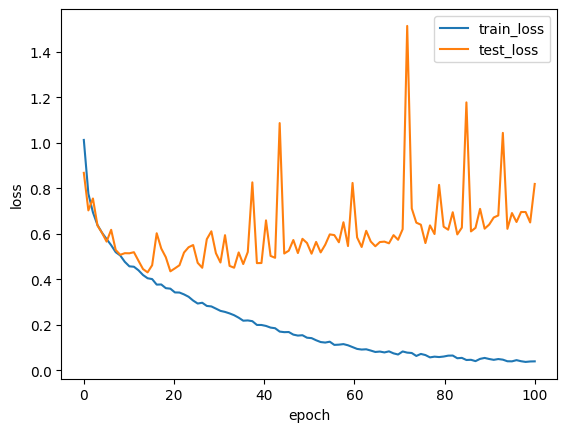

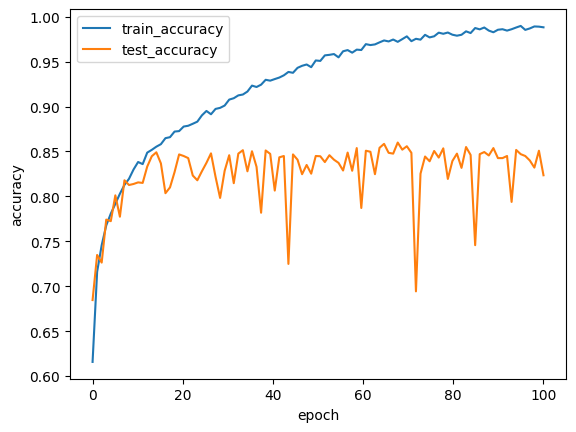

In [5]:
def draw_(x, train_Y, test_Y, ylabel):
    plt.plot(x, train_Y, label='train_' + ylabel, linewidth=1.5)
    plt.plot(x, test_Y, label='test_' + ylabel, linewidth=1.5)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.legend()  # 加上图例
    plt.show()


# 绘制loss曲线
x = np.linspace(0, len(train_loss_list), len(train_loss_list))
draw_(x, train_loss_list, test_loss_list, 'loss')
draw_(x, train_acc_list, test_acc_list, 'accuracy')

In [6]:
class ConvModule(torch.nn.Module):
    def __init__(self):
        super(ConvModule,self).__init__()
        #定义六层卷积层
        #两层HDC（1,2,5,1,2,5）
        self.conv = torch.nn.Sequential(
            #第一层 (3-1)*1+1=3 （64-3)/1 + 1 =62
            torch.nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 3 , stride = 1,padding=0,dilation=1),
            torch.nn.BatchNorm2d(32),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第二层 (3-1)*2+1=5 （62-5)/1 + 1 =58
            torch.nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3 , stride = 1,padding=0,dilation=2),
            torch.nn.BatchNorm2d(32),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            #第三层 (3-1)*5+1=11  (58-11)/1 +1=48
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=5),
            torch.nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
             #第四层(3-1)*1+1=3 （48-3)/1 + 1 =46
            torch.nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=1),
            torch.nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            torch.nn.ReLU(inplace=True),
            # #第五层 (3-1)*2+1=5 （46-5)/1 + 1 =42
            # torch.nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3 , stride = 1,padding=0,dilation=2),
            # torch.nn.BatchNorm2d(64),
            # # inplace-选择是否进行覆盖运算
            # torch.nn.ReLU(inplace=True),
            # #第六层 (3-1)*5+1=11  (42-11)/1 +1=32
            # torch.nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3 , stride = 1,padding=0,dilation=5),
            # torch.nn.BatchNorm2d(128),
            # # inplace-选择是否进行覆盖运算
            # torch.nn.ReLU(inplace=True)

        )
        #输出层,将通道数变为分类数量
        self.fc = torch.nn.Linear(64,num_classes)
    def forward(self,x):
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)
        out = self.conv(x)
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）
        out = F.avg_pool2d(out,32)
         #将张量out从shape batchx128x1x1 变为 batch x128
        out = out.squeeze()
        #输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out


net = ConvModule()
net.to(device)
# 损失函数和优化器
loss = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 模型训练与测试
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # 下面老是报错 shape 不一致

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
num_epochs = 100

for epoch in range(num_epochs):
    # 在训练集上训练
    train_loss, train_acc = train(net, data_loader=train_iter, device=device)
    # 测试集上验证
    test_loss, test_acc = test(net, data_loader=test_iter, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss: %.4f, train acc: %.3f' % (epoch + 1, train_loss, train_acc))
    print('test loss: %.4f, test acc: %.3f' % (test_loss, test_acc))

loss: 1.8981  acc: 0.1250
loss: 1.7629  acc: 0.1250
loss: 1.7259  acc: 0.3125
loss: 1.8174  acc: 0.3125
loss: 1.6963  acc: 0.4375
loss: 1.8207  acc: 0.2500
loss: 1.7838  acc: 0.1875
loss: 1.5329  acc: 0.6250
loss: 1.7781  acc: 0.2500
loss: 1.5837  acc: 0.3750
loss: 1.5264  acc: 0.5000
loss: 1.7376  acc: 0.2500
loss: 1.5075  acc: 0.4375
loss: 1.7357  acc: 0.2500
loss: 1.6570  acc: 0.1875
loss: 1.5315  acc: 0.5000
loss: 1.5330  acc: 0.3125
loss: 1.4811  acc: 0.3125
loss: 1.4027  acc: 0.5000
loss: 1.5722  acc: 0.3750
loss: 1.5380  acc: 0.6250
loss: 1.3512  acc: 0.5625
loss: 1.3467  acc: 0.5000
loss: 1.3972  acc: 0.5000
loss: 1.3675  acc: 0.3750
loss: 1.3799  acc: 0.5000
loss: 1.4218  acc: 0.4375
loss: 1.2075  acc: 0.5000
loss: 1.4489  acc: 0.3125
loss: 1.4466  acc: 0.5000
loss: 1.7432  acc: 0.3750
loss: 1.4377  acc: 0.2500
loss: 1.5458  acc: 0.1250
loss: 1.3601  acc: 0.4375
loss: 1.5005  acc: 0.3750
loss: 1.6062  acc: 0.4375
loss: 1.5235  acc: 0.3750
loss: 1.3233  acc: 0.5000
loss: 1.6001

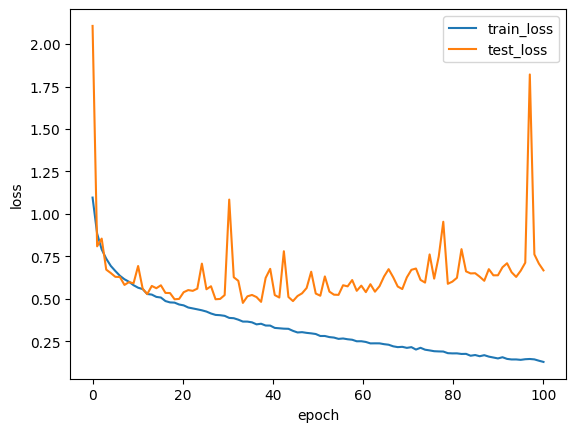

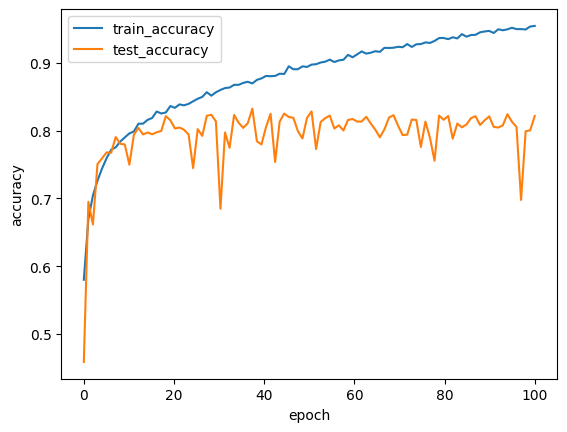

In [7]:
def draw_(x, train_Y, test_Y, ylabel):
    plt.plot(x, train_Y, label='train_' + ylabel, linewidth=1.5)
    plt.plot(x, test_Y, label='test_' + ylabel, linewidth=1.5)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.legend()  # 加上图例
    plt.show()


# 绘制loss曲线
x = np.linspace(0, len(train_loss_list), len(train_loss_list))
draw_(x, train_loss_list, test_loss_list, 'loss')
draw_(x, train_acc_list, test_acc_list, 'accuracy')

In [19]:
#残差网络块
#每个残差块都是两层
#默认3*3卷积下padding为1，则大小不会变化，如变化则是步长引起的。
class ResidualBlock(torch.nn.Module):
	def __init__(self, nin, nout, size, stride=1, shortcut=True):
	    super(ResidualBlock, self).__init__()
	    #两层卷积层
	    #不同步长只有第一层卷积层不同
	    self.block1 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, padding=1),
	                                torch.nn.BatchNorm2d(nout),
	                                torch.nn.ReLU(inplace=True),
	                                torch.nn.Conv2d(nout, nout, size, 1, padding=1),
	                                torch.nn.BatchNorm2d(nout))
	    self.shortcut = shortcut
	    #解决通道数变化以及步长不为1引起的图片大小的变化
	    self.block2 = torch.nn.Sequential(torch.nn.Conv2d(nin, nout, size, stride, 1),
	                                torch.nn.BatchNorm2d(nout))
	    self.relu = torch.nn.ReLU(inplace=True)

	def forward(self, input):
	    x = input
	    out = self.block1(x)
	    '''''若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道'''
	    if self.shortcut:
	        out = x + out
	    else:
	        out = out + self.block2(x)
	    out = self.relu(out)
	    return out



In [22]:
#定义给定的残差结构
class resnet(torch.nn.Module):
	def __init__(self):
	    super(resnet, self).__init__()
	    self.block = torch.nn.Sequential(torch.nn.Conv2d(3, 64, 3, stride=1, padding=1),
	                                torch.nn.BatchNorm2d(64),
	                                torch.nn.ReLU())
	    #t表示2个相同的残差块,每个残差块两个卷积
	    self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
	    self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
	    self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
	    self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)

	    self.avgp = torch.nn.AvgPool2d(8)
	    self.exit = torch.nn.Linear(512, 6)

	def make_layer(self, in1, out1, ksize, stride, t):
	    layers = []
	    for i in range(0, t):
	        if i == 0 and in1 != out1:
	            layers.append(ResidualBlock(in1, out1, ksize, stride, None))
	        else:
	            layers.append(ResidualBlock(out1, out1, ksize, 1, True))
	    return torch.nn.Sequential(*layers)

	def forward(self, input):
	    x = self.block(input)  # 输出维度 64 * 64 * 64    C * H * W
	    x = self.d1(x)  # 输出维度 64 * 54 * 54
	    x = self.d2(x)  # i=0 步长为2，输出维度128 * 32 * 32
	    x = self.d3(x)  # i=0 步长为2，输出维度256 * 16 * 16
	    x = self.d4(x)  # i=0 步长为2，输出维度512 * 8 * 8
	    x = self.avgp(x)  # 512 * 1 * 1
	    #将张量out从shape batchx512x1x1 变为 batch x512
	    x = x.squeeze()
	    output = self.exit(x)
	    return output



In [25]:
import torch
torch.cuda.current_device()
import torchvision
net = resnet()
net.to(device)
# 损失函数和优化器
loss = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 模型训练与测试
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # 下面老是报错 shape 不一致

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
num_epochs = 50

for epoch in range(num_epochs):
    # 在训练集上训练
    train_loss, train_acc = train(net, data_loader=train_iter, device=device)
    # 测试集上验证
    test_loss, test_acc = test(net, data_loader=test_iter, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss: %.4f, train acc: %.3f' % (epoch + 1, train_loss, train_acc))
    print('test loss: %.4f, test acc: %.3f' % (test_loss, test_acc))

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.